In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [2]:
import warnings
warnings.filterwarnings("ignore")

# INPUT 

In [3]:
dataset = pd.read_csv(r"D:\TCA Dump\To Sachin/datewise_bit_pattern_unpivot.csv",parse_dates=['down_date'])
dataset.head(2)

,ipaddress,down_date,day,hour,bit_prob,date_hour
0,10.10.113.210,2023-06-04,Sunday,0,0.0,2023-06-04 00:00:00
1,10.10.113.210,2023-06-04,Sunday,1,0.0,2023-06-04 01:00:00


In [4]:
df1 = pd.read_csv(r"D:\TCA Dump/DL_NCR_Device_Type.csv")

In [5]:
dataset = pd.merge(dataset, df1, on = 'ipaddress', how = 'inner')
dataset.head(2)

,ipaddress,down_date,day,hour,bit_prob,date_hour,Device Type
0,10.10.113.210,2023-06-04,Sunday,0,0.0,2023-06-04 00:00:00,AP
1,10.10.113.210,2023-06-04,Sunday,1,0.0,2023-06-04 01:00:00,AP


In [6]:
dataset = dataset[dataset['Device Type'] == 'SM']

In [7]:
dataset = dataset[['ipaddress', 'down_date', 'day', 'hour', 'bit_prob', 'date_hour']]

In [8]:
dataset.head(2)

,ipaddress,down_date,day,hour,bit_prob,date_hour
1464,10.10.113.211,2023-06-04,Sunday,0,0.0,2023-06-04 00:00:00
1465,10.10.113.211,2023-06-04,Sunday,1,0.0,2023-06-04 01:00:00


In [9]:
df=dataset.copy()

In [10]:
# df = df[df['ipaddress'] == '10.28.127.131']
df = df[df['ipaddress'] == '10.3.187.228']
# df = df[df['ipaddress'] == '10.5.62.172']
# df = df[df['ipaddress'] == '10.9.135.19']
# df = df[df['ipaddress'] == '10.71.224.77']
# df = df[df['ipaddress'] == '10.28.45.248']

# df = df[df['ipaddress'] == '10.4.172.195']



In [11]:
df = df[['date_hour', 'bit_prob']]

In [12]:
df.head(2)

,date_hour,bit_prob
3153456,2023-06-04 00:00:00,0.0
3153457,2023-06-04 01:00:00,0.0


In [13]:
df['date_hour'] = pd.to_datetime(df['date_hour'])

In [14]:
df.head(2)

,date_hour,bit_prob
3153456,2023-06-04 00:00:00,0.0
3153457,2023-06-04 01:00:00,0.0


In [15]:
df.set_index('date_hour', inplace=True)

In [16]:
df.head(3)

,bit_prob
date_hour,
2023-06-04 00:00:00,0.0
2023-06-04 01:00:00,0.0
2023-06-04 02:00:00,0.0


In [17]:
len(df)

1464

In [18]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['bit_prob']=scaler.fit_transform(df['bit_prob'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(1464, 1)

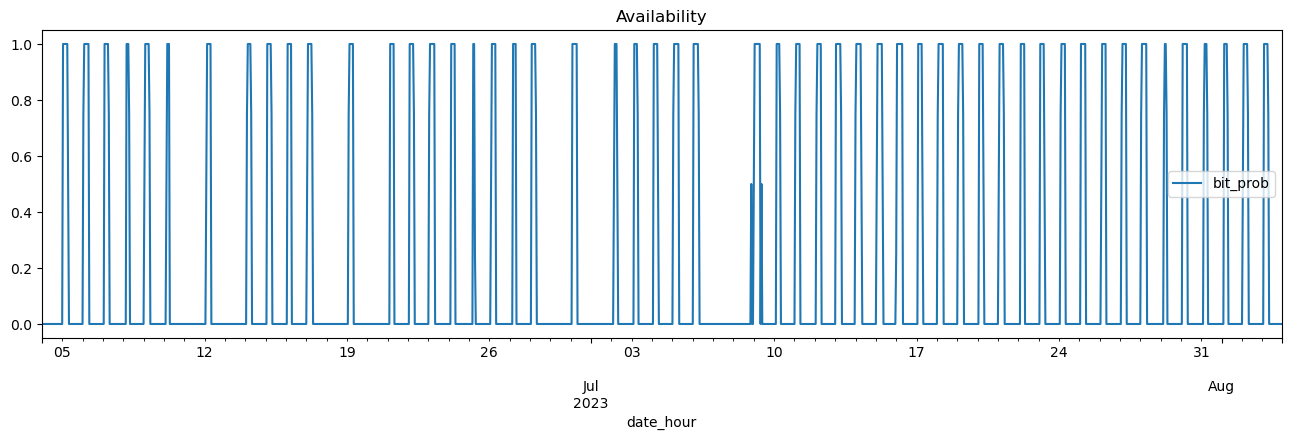

In [19]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('Availability')

plt.show()

# Prepare Data for LSTM Model

In [20]:
def load_data(availability, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(availability)):
        X_train.append(availability.iloc[i-seq_len : i, 0])
        y_train.append(availability.iloc[i, 0])
    
    #1 last 288 rows are going to be used in test
    X_test = X_train[1176:]             
    y_test = y_train[1176:]
    
    #2 first 1176 rows are going to be used in training
    X_train = X_train[:1176]           
    y_train = y_train[:1176]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (1176, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [21]:
seq_len = 24 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1176, 24, 1)
y_train.shape =  (1176,)
X_test.shape =  (264, 24, 1)
y_test.shape =  (264,)


# Build LSTM Model

In [22]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 24, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 24, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [23]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, batch_size=10, epochs=100 )

Epoch 1/100
118/118 [==============================] - 9s 27ms/step - loss: 0.1128
Epoch 2/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0793
Epoch 3/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0721
Epoch 4/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0645
Epoch 5/100
118/118 [==============================] - 3s 22ms/step - loss: 0.0602
Epoch 6/100
118/118 [==============================] - 3s 22ms/step - loss: 0.0565
Epoch 7/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0577
Epoch 8/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0530
Epoch 9/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0527
Epoch 10/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0499
Epoch 11/100
118/118 [==============================] - 4s 31ms/step - loss: 0.0479
Epoch 12/100
118/118 [==============================] - 3s 28ms/step - loss: 0.0451
E

118/118 [==============================] - 3s 22ms/step - loss: 0.0299
Epoch 99/100
118/118 [==============================] - 3s 23ms/step - loss: 0.0281
Epoch 100/100
118/118 [==============================] - 3s 22ms/step - loss: 0.0324


In [24]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

9/9 [==============================] - 2s 11ms/step
R^2 Score of LSTM model =  0.8980616341607321


In [25]:
# plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

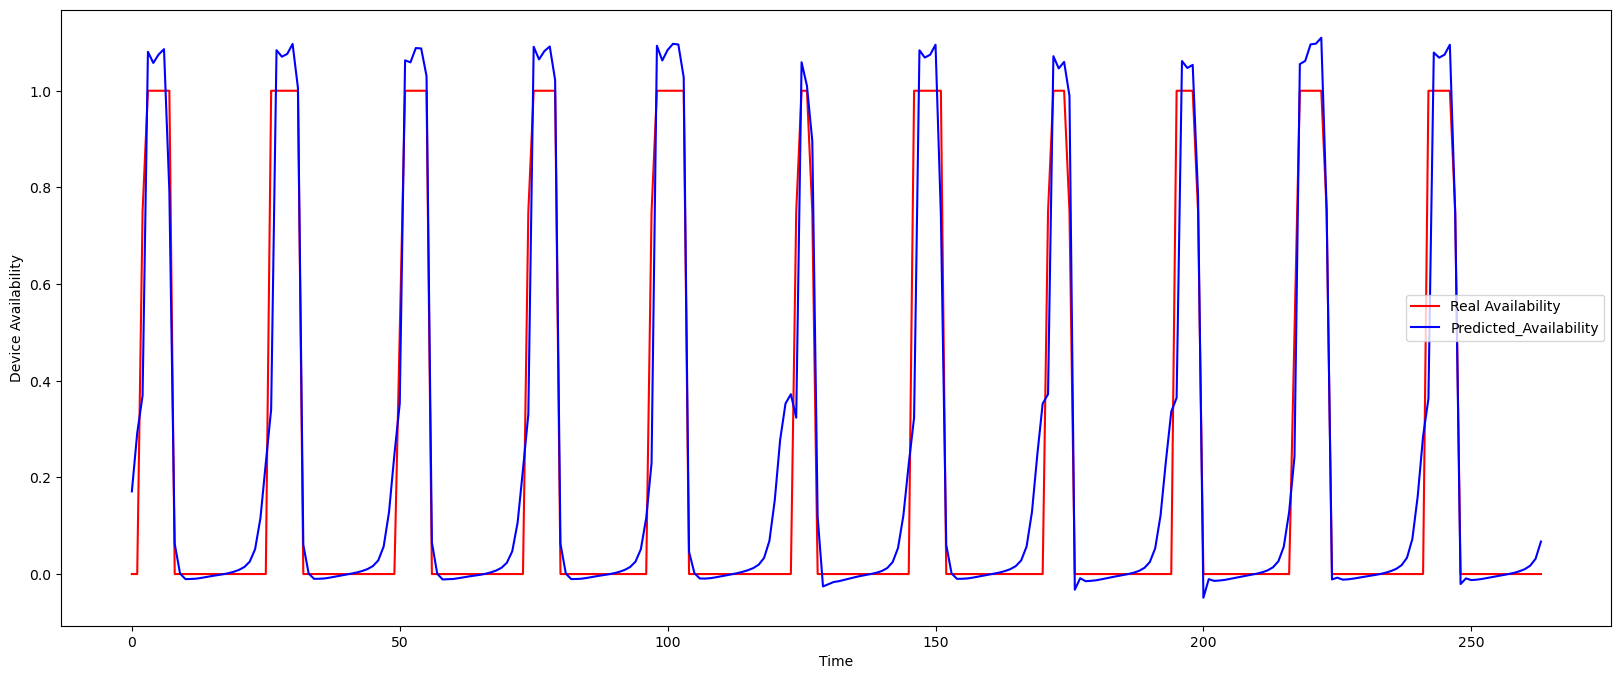

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, color = 'red', label = 'Real Availability')
plt.plot(lstm_predictions, color = 'blue', label = 'Predicted_Availability')
plt.xlabel("Time")
plt.ylabel("Device Availability")
plt.legend()
plt.show()

# Predict Next 24 hours Availability Pattern

In [27]:
def predict_next_24_hours(model, historical_data):
    predictions = []
    for i in range(24):
        most_recent_sequence = historical_data.iloc[-seq_len:, 0]          
        most_recent_sequence = np.reshape(most_recent_sequence.values, (1, seq_len, 1))
        predicted_availability = model.predict(most_recent_sequence)
        predictions.append(predicted_availability[0][0])
        last_date_hour = historical_data.index[-1]
        next_hour = last_date_hour + pd.Timedelta(hours=1)
        historical_data = historical_data.append(pd.DataFrame({'bit_prob': [predicted_availability[0][0]]}, index=[next_hour]))
    return predictions

predicted_next_24_hours = predict_next_24_hours(lstm_model, df)

print("Predicted Availability for the Next 24 Hours:")
print(predicted_next_24_hours)



1/1 [==============================] - 0s 29ms/step
Predicted Availability for the Next 24 Hours:
[0.14999677, 0.5336973, 1.0561928, 1.0683937, 1.098396, 1.1056978, 1.1226088, 0.8102375, -0.01559101, -0.007910833, -0.012145832, -0.011637509, -0.010289907, -0.008501977, -0.006705418, -0.005004868, -0.0033144504, -0.0012882054, 0.001353845, 0.00470943, 0.009166375, 0.016334623, 0.031699926, 0.077791184]


# Visualizing the Predicted Result

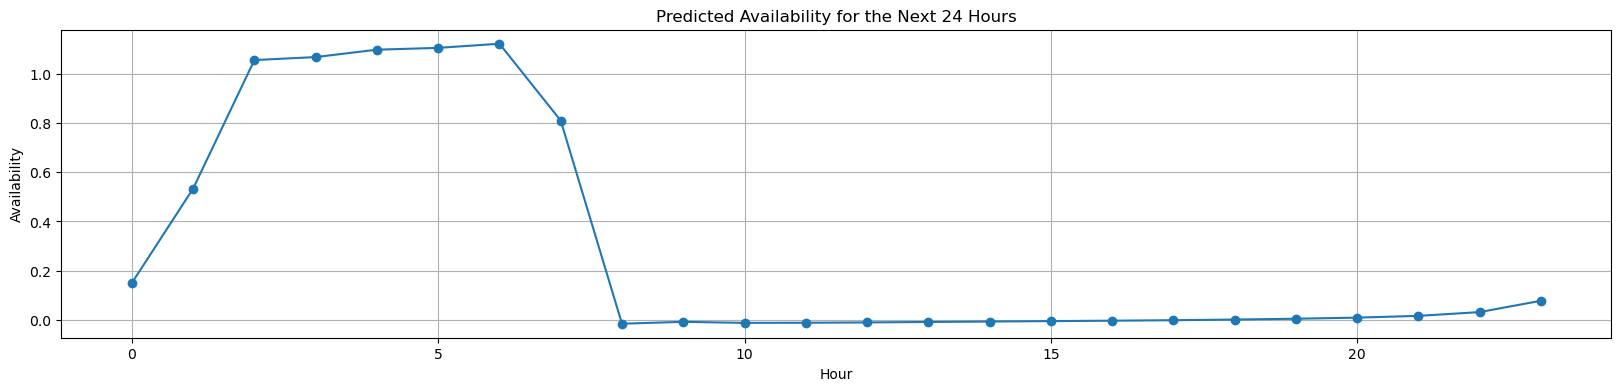

In [31]:
plt.figure(figsize=(20, 4))
plt.plot(predicted_next_24_hours, marker='o', linestyle='-')
plt.title("Predicted Availability for the Next 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Availability")
plt.grid(True)
plt.show()